****Neural Network on Merged Data Minimizing Mean Absolute Percentage Error (MAPE)****

In [67]:
#Author: Bryant
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import statsmodels.api as sma
from statsmodels.stats.outliers_influence import variance_inflation_factor
import keras_tuner as kt

In [68]:
random.seed(12345)

In [69]:
# Importing Data
toyota = pd.read_csv('Merged_Data_with_lag_Lead_Sales.csv', header=0)
toyota.head(20)

,Week,Model,Sales,Region,Website_Visits.Organic.BAT,Website_Visits.Paid.BAT,CTA1.Organic.BAT,CTA1.Paid.BAT,CTA2.Organic.BAT,CTA2.Paid.BAT,...,Impressions.Unknown_Platform.Video,Impressions.NA.Video,Qualified_Actions.Connected_TV.Video,Qualified_Actions.Desktop.Video,Qualified_Actions.Mobile.Video,Qualified_Actions.Unknown_Platform.Video,Qualified_Actions.NA.Video,Week_of_Month,Month_Number,Fin_Year_End
0,2020-10-04,AF,81,Region 1,365,283,343,164,37,6,...,4544,0,0,3792,3184,0,0,1,10,0
1,2020-10-11,AF,84,Region 1,311,303,267,160,5,7,...,2379,0,0,4941,3688,0,0,2,10,0
2,2020-10-18,AF,86,Region 1,165,353,102,297,7,8,...,1405,0,0,5874,4041,0,0,3,10,0
3,2020-10-25,AF,101,Region 1,84,343,73,296,2,11,...,233,0,0,5833,3301,0,0,4,10,0
4,2020-11-01,AF,79,Region 1,89,325,88,295,1,9,...,38,0,0,4671,2645,0,0,1,11,0
5,2020-11-08,AF,68,Region 1,105,321,114,285,5,8,...,150,0,0,5312,3314,0,0,2,11,0
6,2020-11-15,AF,79,Region 1,112,331,108,341,5,11,...,151,0,0,5242,3166,0,0,3,11,0
7,2020-11-22,AF,74,Region 1,84,375,58,297,7,14,...,11,0,0,4272,3209,0,0,4,11,0
8,2020-11-29,AF,81,Region 1,76,280,58,257,5,5,...,1554,0,0,4576,2625,0,0,5,11,0
9,2020-12-06,AF,59,Region 1,69,313,69,263,5,11,...,39969,0,0,4571,3052,0,0,1,12,0


In [70]:
toyota = toyota[toyota.Region != 'Region 13']

In [71]:
toyota.shape

(1500, 99)

In [72]:
covidcars = pd.read_csv('covid_sp_carz.csv', header=0)

In [73]:
covidcars.shape

(39, 23)

In [74]:
covidcars = covidcars.drop('Unnamed: 1',axis=1)
covidcars = covidcars.drop('SP_Date',axis=1)
covidcars = covidcars.drop('Carz_Date',axis=1)

In [75]:
covidcars.shape

(39, 20)

In [76]:
covid_collist = ['date','SP_Open','SP_High','SP_Low','SP_Close','Carz_Open','Carz_High','Carz_Low','Carz_Close','US_Monthly_Employment_Level','US_Avg_Weekly_Employment_Level']
covid = covidcars[covid_collist]

In [77]:
covid

,date,SP_Open,SP_High,SP_Low,SP_Close,Carz_Open,Carz_High,Carz_Low,Carz_Close,US_Monthly_Employment_Level,US_Avg_Weekly_Employment_Level
0,10/4/2020,3333.90,3397.18,3323.69,3348.44,39.330002,39.490002,38.549999,39.290001,149.70,34.070
1,10/11/2020,3367.27,3482.34,3354.54,3477.13,39.860001,40.820000,39.689999,40.759998,149.70,33.803
2,10/18/2020,3500.02,3549.85,3440.89,3483.81,40.759998,41.200001,39.730000,40.599998,149.70,33.803
3,10/25/2020,3493.66,3502.42,3415.34,3465.39,40.389999,41.750000,40.330002,41.459999,149.70,33.803
4,11/1/2020,3441.42,3441.42,3233.94,3269.96,40.869999,41.209999,39.020000,39.349998,149.81,33.964
5,11/8/2020,3296.20,3529.05,3279.74,3509.44,40.509998,44.000000,40.509998,43.660000,149.81,34.930
6,11/15/2020,3583.04,3645.99,3511.91,3585.15,45.860001,46.930000,44.570000,45.930000,149.81,34.930
7,11/22/2020,3600.16,3628.51,3543.84,3557.54,46.570000,48.470001,46.570000,48.410000,149.81,34.930
8,11/29/2020,3566.82,3644.31,3552.77,3638.35,48.990002,50.680000,48.990002,49.400002,149.81,34.930
9,12/6/2020,3634.18,3699.20,3594.39,3699.12,49.400002,50.000000,47.930000,50.000000,149.83,33.988


In [78]:
toyota.index = pd.to_datetime(toyota['Week'])
toyota = toyota.drop(['Week'], axis= 1)

In [79]:
covid.index = pd.to_datetime(covid['date'])
covid = covid.drop(['date'], axis= 1)

In [80]:
toyota

,Model,Sales,Region,Website_Visits.Organic.BAT,Website_Visits.Paid.BAT,CTA1.Organic.BAT,CTA1.Paid.BAT,CTA2.Organic.BAT,CTA2.Paid.BAT,Website_Visits.Organic.TCOM,...,Impressions.Unknown_Platform.Video,Impressions.NA.Video,Qualified_Actions.Connected_TV.Video,Qualified_Actions.Desktop.Video,Qualified_Actions.Mobile.Video,Qualified_Actions.Unknown_Platform.Video,Qualified_Actions.NA.Video,Week_of_Month,Month_Number,Fin_Year_End
Week,,,,,,,,,,,,,,,,,,,,,
2020-10-04,AF,81,Region 1,365,283,343,164,37,6,1022,...,4544,0,0,3792,3184,0,0,1,10,0
2020-10-11,AF,84,Region 1,311,303,267,160,5,7,1017,...,2379,0,0,4941,3688,0,0,2,10,0
2020-10-18,AF,86,Region 1,165,353,102,297,7,8,1022,...,1405,0,0,5874,4041,0,0,3,10,0
2020-10-25,AF,101,Region 1,84,343,73,296,2,11,902,...,233,0,0,5833,3301,0,0,4,10,0
2020-11-01,AF,79,Region 1,89,325,88,295,1,9,1049,...,38,0,0,4671,2645,0,0,1,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-21,AW,116,Region 9,52,124,43,110,1,4,4854,...,124,0,0,518,394,0,0,3,2,0
2021-02-28,AW,141,Region 9,46,105,53,114,1,1,4072,...,97,0,0,579,550,0,0,4,2,0
2021-03-07,AW,151,Region 9,43,96,46,85,0,2,3771,...,75,0,0,451,504,0,0,1,3,1


In [81]:
covid

,SP_Open,SP_High,SP_Low,SP_Close,Carz_Open,Carz_High,Carz_Low,Carz_Close,US_Monthly_Employment_Level,US_Avg_Weekly_Employment_Level
date,,,,,,,,,,
2020-10-04,3333.90,3397.18,3323.69,3348.44,39.330002,39.490002,38.549999,39.290001,149.70,34.070
2020-10-11,3367.27,3482.34,3354.54,3477.13,39.860001,40.820000,39.689999,40.759998,149.70,33.803
2020-10-18,3500.02,3549.85,3440.89,3483.81,40.759998,41.200001,39.730000,40.599998,149.70,33.803
2020-10-25,3493.66,3502.42,3415.34,3465.39,40.389999,41.750000,40.330002,41.459999,149.70,33.803
2020-11-01,3441.42,3441.42,3233.94,3269.96,40.869999,41.209999,39.020000,39.349998,149.81,33.964
2020-11-08,3296.20,3529.05,3279.74,3509.44,40.509998,44.000000,40.509998,43.660000,149.81,34.930
2020-11-15,3583.04,3645.99,3511.91,3585.15,45.860001,46.930000,44.570000,45.930000,149.81,34.930
2020-11-22,3600.16,3628.51,3543.84,3557.54,46.570000,48.470001,46.570000,48.410000,149.81,34.930
2020-11-29,3566.82,3644.31,3552.77,3638.35,48.990002,50.680000,48.990002,49.400002,149.81,34.930


In [82]:
pd.merge(toyota,covid, how='inner', left_index=True, right_index=True)

,Model,Sales,Region,Website_Visits.Organic.BAT,Website_Visits.Paid.BAT,CTA1.Organic.BAT,CTA1.Paid.BAT,CTA2.Organic.BAT,CTA2.Paid.BAT,Website_Visits.Organic.TCOM,...,SP_Open,SP_High,SP_Low,SP_Close,Carz_Open,Carz_High,Carz_Low,Carz_Close,US_Monthly_Employment_Level,US_Avg_Weekly_Employment_Level
2020-10-04,AF,81,Region 1,365,283,343,164,37,6,1022,...,3333.90,3397.18,3323.69,3348.44,39.330002,39.490002,38.549999,39.290001,149.70,34.070
2020-10-04,AF,61,Region 10,199,361,129,93,4,1,1023,...,3333.90,3397.18,3323.69,3348.44,39.330002,39.490002,38.549999,39.290001,149.70,34.070
2020-10-04,AF,159,Region 11,264,213,110,63,4,2,2039,...,3333.90,3397.18,3323.69,3348.44,39.330002,39.490002,38.549999,39.290001,149.70,34.070
2020-10-04,AF,676,Region 12,20,8,23,6,0,0,3988,...,3333.90,3397.18,3323.69,3348.44,39.330002,39.490002,38.549999,39.290001,149.70,34.070
2020-10-04,AF,215,Region 2,509,855,168,231,6,10,2640,...,3333.90,3397.18,3323.69,3348.44,39.330002,39.490002,38.549999,39.290001,149.70,34.070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-21,AW,313,Region 5,160,325,233,260,3,5,5082,...,3942.96,3983.87,3886.75,3913.10,57.389999,59.189999,56.830002,58.560001,150.85,34.062
2021-03-21,AW,344,Region 6,208,214,186,233,5,9,5515,...,3942.96,3983.87,3886.75,3913.10,57.389999,59.189999,56.830002,58.560001,150.85,34.062
2021-03-21,AW,86,Region 7,7,2,12,2,0,0,2447,...,3942.96,3983.87,3886.75,3913.10,57.389999,59.189999,56.830002,58.560001,150.85,34.062
2021-03-21,AW,311,Region 8,544,702,457,359,8,4,5598,...,3942.96,3983.87,3886.75,3913.10,57.389999,59.189999,56.830002,58.560001,150.85,34.062


In [83]:
toyota = pd.merge(toyota,covid, how='inner', left_index=True, right_index=True)

In [84]:
# Selecting predictor variables
col_list = ['Sales', 'Model','Region','CTA2.Paid.BAT','Website_Visits.Paid.TCOM','CTA1.Organic.TCOM','CTA1.Paid.TCOM','CTA2.Organic.TCOM','CTA2.Paid.TCOM','Lead_Sales.Category_7',
            'Lead_Sales.Category_5','Lead_Sales.Category_6','Lead_Sales.Category_4','Lead_Sales.Category_9','Lead_Sales.Category_7_lag1','Lead_Sales.Category_7_lag2',
            'Lead_Sales.Category_5_lag1','Lead_Sales.Category_5_lag3','Lead_Sales.Category_4_lag2','Lead_Sales.Category_4_lag3','Lead_Sales.Category_4_lag4','Lead_Sales.Category_9_lag1',
            'Lead_Sales.Category_9_lag2','Impressions.Desktop.Display','Qualified_Actions.NA.Social','Impressions.Connected_TV.Video','Qualified_Actions.Mobile.Video','Week_of_Month',
            'SP_Open','SP_Close','Carz_Open','Carz_Close','US_Monthly_Employment_Level']

In [19]:
toyota = toyota[col_list]

In [85]:
len(col_list)

33

In [20]:
toyota.shape

(1500, 33)

In [21]:
# Variance Inflation Factor (VIF)
def vif_arr(df):
    vif = pd.DataFrame()
    df=sma.add_constant(df)
    vif['variables'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    
    return(vif)

In [22]:
# Dummy Variables for Model
dummies_model = pd.get_dummies(toyota.Model)
dummies_model

,AF,AH,AL,AR,AW
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
...,...,...,...,...,...
2021-03-21,0,0,0,0,1
2021-03-21,0,0,0,0,1
2021-03-21,0,0,0,0,1
2021-03-21,0,0,0,0,1


In [23]:
# Dummy Variables for Region (1-12, removing Region 13)
dummies_region = pd.get_dummies(toyota.Region)
dummies_region

,Region 1,Region 10,Region 11,Region 12,Region 2,Region 3,Region 4,Region 5,Region 6,Region 7,Region 8,Region 9
2020-10-04,1,0,0,0,0,0,0,0,0,0,0,0
2020-10-04,0,1,0,0,0,0,0,0,0,0,0,0
2020-10-04,0,0,1,0,0,0,0,0,0,0,0,0
2020-10-04,0,0,0,1,0,0,0,0,0,0,0,0
2020-10-04,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-21,0,0,0,0,0,0,0,1,0,0,0,0
2021-03-21,0,0,0,0,0,0,0,0,1,0,0,0
2021-03-21,0,0,0,0,0,0,0,0,0,1,0,0
2021-03-21,0,0,0,0,0,0,0,0,0,0,1,0


In [24]:
# Dummy Variables for Week_of_Month (1-5)
dummies_Week_of_Month = pd.get_dummies(toyota, columns=['Week_of_Month'])
dummies_Week_of_Month = dummies_Week_of_Month.loc[:,'Week_of_Month_1':'Week_of_Month_5']
dummies_Week_of_Month

,Week_of_Month_1,Week_of_Month_2,Week_of_Month_3,Week_of_Month_4,Week_of_Month_5
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
2020-10-04,1,0,0,0,0
...,...,...,...,...,...
2021-03-21,0,0,1,0,0
2021-03-21,0,0,1,0,0
2021-03-21,0,0,1,0,0
2021-03-21,0,0,1,0,0


In [25]:
# Replacing old categorical features with dummy variables
newtoyota = pd.concat([toyota,dummies_model,dummies_region,dummies_Week_of_Month],axis='columns')

del newtoyota['Model']
del newtoyota['Region']
del newtoyota['Week_of_Month']
#del newtoyota['Month_Number']

In [26]:
# Filling NA values
newtoyota = newtoyota.fillna(0)
# Checking the replaced NA values
# newtoyota.loc[:,'positive_rate':'new_vaccinations']

In [27]:
# Checks for empty columns and removes them
newtoyota=newtoyota.loc[:, (newtoyota.sum(axis=0) != 0)]

In [28]:
newtoyota.shape

(1500, 52)

In [29]:
newtoyota.head()

,Sales,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,...,Region 5,Region 6,Region 7,Region 8,Region 9,Week_of_Month_1,Week_of_Month_2,Week_of_Month_3,Week_of_Month_4,Week_of_Month_5
2020-10-04,81,6,971,512,399,83,70,0,2,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,61,1,998,488,349,69,55,3,4,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,159,2,2187,975,768,171,153,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,676,0,4077,2073,1471,51,42,10,4,0,...,0,0,0,0,0,1,0,0,0,0
2020-10-04,215,10,2797,1259,1034,177,141,2,4,1,...,0,0,0,0,0,1,0,0,0,0


In [30]:
newtoyota.columns

Index(['Sales', 'CTA2.Paid.BAT', 'Website_Visits.Paid.TCOM',
       'CTA1.Organic.TCOM', 'CTA1.Paid.TCOM', 'CTA2.Organic.TCOM',
       'CTA2.Paid.TCOM', 'Lead_Sales.Category_7', 'Lead_Sales.Category_5',
       'Lead_Sales.Category_6', 'Lead_Sales.Category_4',
       'Lead_Sales.Category_9', 'Lead_Sales.Category_7_lag1',
       'Lead_Sales.Category_7_lag2', 'Lead_Sales.Category_5_lag1',
       'Lead_Sales.Category_5_lag3', 'Lead_Sales.Category_4_lag2',
       'Lead_Sales.Category_4_lag3', 'Lead_Sales.Category_4_lag4',
       'Lead_Sales.Category_9_lag1', 'Lead_Sales.Category_9_lag2',
       'Impressions.Desktop.Display', 'Qualified_Actions.NA.Social',
       'Impressions.Connected_TV.Video', 'Qualified_Actions.Mobile.Video',
       'SP_Open', 'SP_Close', 'Carz_Open', 'Carz_Close',
       'US_Monthly_Employment_Level', 'AF', 'AH', 'AL', 'AR', 'AW', 'Region 1',
       'Region 10', 'Region 11', 'Region 12', 'Region 2', 'Region 3',
       'Region 4', 'Region 5', 'Region 6', 'Region 7', 'Reg

In [31]:
# # Checking Data Types, must change objects to numeric
# print(newtoyota.loc[:,'positive_rate':'SP_Close'].dtypes)

In [32]:
newtoyota.columns

Index(['Sales', 'CTA2.Paid.BAT', 'Website_Visits.Paid.TCOM',
       'CTA1.Organic.TCOM', 'CTA1.Paid.TCOM', 'CTA2.Organic.TCOM',
       'CTA2.Paid.TCOM', 'Lead_Sales.Category_7', 'Lead_Sales.Category_5',
       'Lead_Sales.Category_6', 'Lead_Sales.Category_4',
       'Lead_Sales.Category_9', 'Lead_Sales.Category_7_lag1',
       'Lead_Sales.Category_7_lag2', 'Lead_Sales.Category_5_lag1',
       'Lead_Sales.Category_5_lag3', 'Lead_Sales.Category_4_lag2',
       'Lead_Sales.Category_4_lag3', 'Lead_Sales.Category_4_lag4',
       'Lead_Sales.Category_9_lag1', 'Lead_Sales.Category_9_lag2',
       'Impressions.Desktop.Display', 'Qualified_Actions.NA.Social',
       'Impressions.Connected_TV.Video', 'Qualified_Actions.Mobile.Video',
       'SP_Open', 'SP_Close', 'Carz_Open', 'Carz_Close',
       'US_Monthly_Employment_Level', 'AF', 'AH', 'AL', 'AR', 'AW', 'Region 1',
       'Region 10', 'Region 11', 'Region 12', 'Region 2', 'Region 3',
       'Region 4', 'Region 5', 'Region 6', 'Region 7', 'Reg

In [33]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(newtoyota, test_size=0.3)

In [34]:
# # Split Training and Testing Data
# train = newtoyota.sample(frac = 0.7, random_state=0)
# test = newtoyota.drop(train.index)

In [35]:
# Correlation Matrix for Continuous Variables
correlation_matrix = train.loc[:,'Sales':'US_Monthly_Employment_Level'].corr()
correlation_matrix

,Sales,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,...,Lead_Sales.Category_9_lag2,Impressions.Desktop.Display,Qualified_Actions.NA.Social,Impressions.Connected_TV.Video,Qualified_Actions.Mobile.Video,SP_Open,SP_Close,Carz_Open,Carz_Close,US_Monthly_Employment_Level
Sales,1.000000,0.089479,0.649135,0.349205,0.191447,0.192754,0.215596,0.252267,0.186202,-0.054131,...,0.040545,0.142247,-0.052465,0.036642,0.113543,0.036201,0.027309,0.009961,0.013988,0.064967
CTA2.Paid.BAT,0.089479,1.000000,0.090678,0.051430,-0.025550,0.304381,0.310105,-0.168139,0.103854,0.039752,...,0.062690,0.137710,0.042324,0.097896,0.121291,-0.041117,-0.030194,-0.045057,-0.032957,-0.008356
Website_Visits.Paid.TCOM,0.649135,0.090678,1.000000,0.608552,0.550666,0.521431,0.572952,0.395271,0.258441,0.137200,...,-0.004479,0.170570,0.178774,-0.018702,-0.020690,0.186809,0.225541,0.198214,0.215999,0.209161
CTA1.Organic.TCOM,0.349205,0.051430,0.608552,1.000000,0.399742,0.578695,0.539938,0.494870,0.320476,0.241731,...,0.042242,0.104009,0.318948,-0.008470,-0.092317,0.086997,0.098736,0.105022,0.103991,0.005793
CTA1.Paid.TCOM,0.191447,-0.025550,0.550666,0.399742,1.000000,0.347395,0.382373,0.473051,0.301891,0.265117,...,0.029961,0.147859,0.191247,0.065594,-0.064454,-0.030885,-0.004949,-0.039291,-0.024885,0.113882
CTA2.Organic.TCOM,0.192754,0.304381,0.521431,0.578695,0.347395,1.000000,0.958966,0.276956,0.126802,0.385968,...,-0.039013,0.164572,0.258200,0.102679,-0.022600,-0.022508,-0.003741,-0.023723,-0.014971,0.006626
CTA2.Paid.TCOM,0.215596,0.310105,0.572952,0.539938,0.382373,0.958966,1.000000,0.280387,0.135236,0.392127,...,-0.028402,0.179799,0.257691,0.158189,0.007437,-0.040807,-0.003447,-0.042408,-0.024178,0.019564
Lead_Sales.Category_7,0.252267,-0.168139,0.395271,0.494870,0.473051,0.276956,0.280387,1.000000,0.543535,0.334670,...,0.047905,0.094412,0.205955,0.061153,-0.096644,-0.012975,0.011495,-0.021461,-0.005578,0.013572
Lead_Sales.Category_5,0.186202,0.103854,0.258441,0.320476,0.301891,0.126802,0.135236,0.543535,1.000000,0.296058,...,0.054330,0.112136,0.160526,0.046702,-0.064097,0.081634,0.098377,0.082891,0.087969,0.097964
Lead_Sales.Category_6,-0.054131,0.039752,0.137200,0.241731,0.265117,0.385968,0.392127,0.334670,0.296058,1.000000,...,0.017577,0.110789,0.111866,0.070637,-0.061479,0.002608,0.013391,-0.003674,0.001916,0.042268


In [36]:
abscorr = correlation_matrix.iloc[correlation_matrix.Sales.abs().argsort()]

In [37]:
abscorr.sort_values('Sales', ascending=False, axis=0)

,Sales,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,...,Lead_Sales.Category_9_lag2,Impressions.Desktop.Display,Qualified_Actions.NA.Social,Impressions.Connected_TV.Video,Qualified_Actions.Mobile.Video,SP_Open,SP_Close,Carz_Open,Carz_Close,US_Monthly_Employment_Level
Sales,1.000000,0.089479,0.649135,0.349205,0.191447,0.192754,0.215596,0.252267,0.186202,-0.054131,...,0.040545,0.142247,-0.052465,0.036642,0.113543,0.036201,0.027309,0.009961,0.013988,0.064967
Website_Visits.Paid.TCOM,0.649135,0.090678,1.000000,0.608552,0.550666,0.521431,0.572952,0.395271,0.258441,0.137200,...,-0.004479,0.170570,0.178774,-0.018702,-0.020690,0.186809,0.225541,0.198214,0.215999,0.209161
CTA1.Organic.TCOM,0.349205,0.051430,0.608552,1.000000,0.399742,0.578695,0.539938,0.494870,0.320476,0.241731,...,0.042242,0.104009,0.318948,-0.008470,-0.092317,0.086997,0.098736,0.105022,0.103991,0.005793
Lead_Sales.Category_7_lag1,0.262806,-0.182366,0.392623,0.462810,0.443009,0.244461,0.251865,0.716985,0.512135,0.332141,...,0.016553,0.036049,0.195538,0.012800,-0.115655,0.091065,0.085022,0.067178,0.073930,0.039977
Lead_Sales.Category_7,0.252267,-0.168139,0.395271,0.494870,0.473051,0.276956,0.280387,1.000000,0.543535,0.334670,...,0.047905,0.094412,0.205955,0.061153,-0.096644,-0.012975,0.011495,-0.021461,-0.005578,0.013572
Lead_Sales.Category_7_lag2,0.229177,-0.184916,0.361291,0.448130,0.388323,0.223378,0.218989,0.662894,0.480939,0.292620,...,0.051474,-0.017132,0.208664,-0.064410,-0.126562,0.143943,0.121892,0.125839,0.140116,0.060639
CTA2.Paid.TCOM,0.215596,0.310105,0.572952,0.539938,0.382373,0.958966,1.000000,0.280387,0.135236,0.392127,...,-0.028402,0.179799,0.257691,0.158189,0.007437,-0.040807,-0.003447,-0.042408,-0.024178,0.019564
CTA2.Organic.TCOM,0.192754,0.304381,0.521431,0.578695,0.347395,1.000000,0.958966,0.276956,0.126802,0.385968,...,-0.039013,0.164572,0.258200,0.102679,-0.022600,-0.022508,-0.003741,-0.023723,-0.014971,0.006626
CTA1.Paid.TCOM,0.191447,-0.025550,0.550666,0.399742,1.000000,0.347395,0.382373,0.473051,0.301891,0.265117,...,0.029961,0.147859,0.191247,0.065594,-0.064454,-0.030885,-0.004949,-0.039291,-0.024885,0.113882
Lead_Sales.Category_5,0.186202,0.103854,0.258441,0.320476,0.301891,0.126802,0.135236,0.543535,1.000000,0.296058,...,0.054330,0.112136,0.160526,0.046702,-0.064097,0.081634,0.098377,0.082891,0.087969,0.097964


In [38]:
# Correlation for Continuous Variables Sorted by Sales Descending
correlation_matrix.sort_values('Sales', ascending=False, axis=0)

,Sales,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,...,Lead_Sales.Category_9_lag2,Impressions.Desktop.Display,Qualified_Actions.NA.Social,Impressions.Connected_TV.Video,Qualified_Actions.Mobile.Video,SP_Open,SP_Close,Carz_Open,Carz_Close,US_Monthly_Employment_Level
Sales,1.000000,0.089479,0.649135,0.349205,0.191447,0.192754,0.215596,0.252267,0.186202,-0.054131,...,0.040545,0.142247,-0.052465,0.036642,0.113543,0.036201,0.027309,0.009961,0.013988,0.064967
Website_Visits.Paid.TCOM,0.649135,0.090678,1.000000,0.608552,0.550666,0.521431,0.572952,0.395271,0.258441,0.137200,...,-0.004479,0.170570,0.178774,-0.018702,-0.020690,0.186809,0.225541,0.198214,0.215999,0.209161
CTA1.Organic.TCOM,0.349205,0.051430,0.608552,1.000000,0.399742,0.578695,0.539938,0.494870,0.320476,0.241731,...,0.042242,0.104009,0.318948,-0.008470,-0.092317,0.086997,0.098736,0.105022,0.103991,0.005793
Lead_Sales.Category_7_lag1,0.262806,-0.182366,0.392623,0.462810,0.443009,0.244461,0.251865,0.716985,0.512135,0.332141,...,0.016553,0.036049,0.195538,0.012800,-0.115655,0.091065,0.085022,0.067178,0.073930,0.039977
Lead_Sales.Category_7,0.252267,-0.168139,0.395271,0.494870,0.473051,0.276956,0.280387,1.000000,0.543535,0.334670,...,0.047905,0.094412,0.205955,0.061153,-0.096644,-0.012975,0.011495,-0.021461,-0.005578,0.013572
Lead_Sales.Category_7_lag2,0.229177,-0.184916,0.361291,0.448130,0.388323,0.223378,0.218989,0.662894,0.480939,0.292620,...,0.051474,-0.017132,0.208664,-0.064410,-0.126562,0.143943,0.121892,0.125839,0.140116,0.060639
CTA2.Paid.TCOM,0.215596,0.310105,0.572952,0.539938,0.382373,0.958966,1.000000,0.280387,0.135236,0.392127,...,-0.028402,0.179799,0.257691,0.158189,0.007437,-0.040807,-0.003447,-0.042408,-0.024178,0.019564
CTA2.Organic.TCOM,0.192754,0.304381,0.521431,0.578695,0.347395,1.000000,0.958966,0.276956,0.126802,0.385968,...,-0.039013,0.164572,0.258200,0.102679,-0.022600,-0.022508,-0.003741,-0.023723,-0.014971,0.006626
CTA1.Paid.TCOM,0.191447,-0.025550,0.550666,0.399742,1.000000,0.347395,0.382373,0.473051,0.301891,0.265117,...,0.029961,0.147859,0.191247,0.065594,-0.064454,-0.030885,-0.004949,-0.039291,-0.024885,0.113882
Lead_Sales.Category_5,0.186202,0.103854,0.258441,0.320476,0.301891,0.126802,0.135236,0.543535,1.000000,0.296058,...,0.054330,0.112136,0.160526,0.046702,-0.064097,0.081634,0.098377,0.082891,0.087969,0.097964


In [39]:
# Pairplots
# sns.pairplot(train[['Sales', 'Qualified_Actions.Mobile.Display', 'Qualified_Actions.NA.Social', 'Lead_Sales.Category_7_lag1', 'Lead_Sales.Category_5', 'CTA2.Paid.BAT', 
#             'Impressions.Connected_TV.Video', 'Impressions.Mobile.Video', 'Impressions.Connected_TV.Display', 'Lead_Sales.Category_5_lag4', 'Lead_Sales.Category_7_lag2', 
#             'Lead_Sales.Category_7', 'Website_Visits.Paid.BAT','Website_Visits.Organic.BAT','Lead_Sales.Category_5_lag1','Qualified_Actions.Mobile.Video', 
#             'Impressions.Desktop.Display', 'Impressions.Mobile.Display', 'Impressions.NA.Search', 'Impressions.Unknown_Platform.Video', 'Lead_Sales.Category_7_lag4', 
#             'Lead_Sales.Category_8_lag1', 'Lead_Sales.Category_9', 'Lead_Sales.Category_9_lag4']], diag_kind='kde')

In [40]:
# Statistics of Training Data
trainstat = train.describe()
trainstat.pop('Sales')
trainstat = trainstat.transpose()
trainstat = trainstat.loc['CTA2.Paid.BAT':'US_Monthly_Employment_Level',:]

In [41]:
# Response Variable
trainlabel = train.pop('Sales')
testlabel = test.pop('Sales')

In [42]:
# Normalization
def normalize(x):
    return(x- trainstat['mean']) / trainstat['std']
norm_train = normalize(train.loc[:,'CTA2.Paid.BAT':'US_Monthly_Employment_Level'])
norm_test = normalize(test.loc[:,'CTA2.Paid.BAT':'US_Monthly_Employment_Level'])

In [43]:
trainlabel

2021-01-03    114
2021-01-10    210
2020-11-01    336
2021-02-21    175
2020-10-18    431
             ... 
2021-01-24    111
2021-02-07    225
2020-10-04    146
2020-11-29    476
2020-11-29    302
Name: Sales, Length: 1050, dtype: int64

In [44]:
norm_train.head(5)

,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,Lead_Sales.Category_4,...,Lead_Sales.Category_9_lag2,Impressions.Desktop.Display,Qualified_Actions.NA.Social,Impressions.Connected_TV.Video,Qualified_Actions.Mobile.Video,SP_Open,SP_Close,Carz_Open,Carz_Close,US_Monthly_Employment_Level
2021-01-03,-0.907937,-0.431541,-0.181701,-0.702014,-0.491878,-0.648396,-0.281580,1.429916,2.176014,-0.279048,...,-0.132005,-0.562654,0.072779,-0.575211,1.071435,0.264401,0.362599,0.178767,0.194576,-0.007276
2021-01-10,0.128859,-0.163699,-0.556999,-0.575395,-0.411808,-0.378647,-0.281580,-0.806324,1.208282,6.380049,...,-0.132005,-1.056713,-0.098512,-1.036984,0.144875,0.487546,0.733423,0.379389,0.814546,-0.007276
2020-11-01,2.202450,-0.086250,1.214980,0.512933,1.349748,0.658850,-1.151165,-1.253572,-0.727181,-0.279048,...,-0.132005,-0.226173,-1.590901,-0.869433,-1.012873,-1.246900,-2.264735,-1.409369,-1.727021,-0.636736
2021-02-21,-0.562338,-0.262930,-0.728021,-0.628655,-0.307716,-0.181522,-0.281580,-0.806324,-0.727181,-0.279048,...,-0.132005,0.146276,-0.748022,-0.595830,-0.667896,1.426709,1.176780,1.367188,1.101397,0.593573
2020-10-18,1.338454,1.758796,0.870085,1.175174,2.526788,3.231842,0.298144,0.088172,4.111477,-0.279048,...,-0.132005,1.766965,0.085404,3.055424,1.085885,-0.932415,-1.108915,-1.426216,-1.534245,-0.951466


In [45]:
# Adding the categorical variables back into the training data.
norm_train = pd.concat([norm_train,train.loc[:,'AF':]],axis='columns')
norm_test = pd.concat([norm_test,test.loc[:,'AF':]],axis='columns')

In [46]:
norm_train.head(5)

,CTA2.Paid.BAT,Website_Visits.Paid.TCOM,CTA1.Organic.TCOM,CTA1.Paid.TCOM,CTA2.Organic.TCOM,CTA2.Paid.TCOM,Lead_Sales.Category_7,Lead_Sales.Category_5,Lead_Sales.Category_6,Lead_Sales.Category_4,...,Region 5,Region 6,Region 7,Region 8,Region 9,Week_of_Month_1,Week_of_Month_2,Week_of_Month_3,Week_of_Month_4,Week_of_Month_5
2021-01-03,-0.907937,-0.431541,-0.181701,-0.702014,-0.491878,-0.648396,-0.281580,1.429916,2.176014,-0.279048,...,0,0,1,0,0,1,0,0,0,0
2021-01-10,0.128859,-0.163699,-0.556999,-0.575395,-0.411808,-0.378647,-0.281580,-0.806324,1.208282,6.380049,...,0,0,0,0,0,0,1,0,0,0
2020-11-01,2.202450,-0.086250,1.214980,0.512933,1.349748,0.658850,-1.151165,-1.253572,-0.727181,-0.279048,...,0,1,0,0,0,1,0,0,0,0
2021-02-21,-0.562338,-0.262930,-0.728021,-0.628655,-0.307716,-0.181522,-0.281580,-0.806324,-0.727181,-0.279048,...,0,0,0,1,0,0,0,1,0,0
2020-10-18,1.338454,1.758796,0.870085,1.175174,2.526788,3.231842,0.298144,0.088172,4.111477,-0.279048,...,0,0,0,0,1,0,0,1,0,0


In [47]:
# Building Neural Network with Hyperparameter Tuning
def buildmodel(hp):
    nn = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        nn.add(layers.Dense(units=hp.Int('units_' + str(i),
                                           min_value=32,
                                           max_value=512,
                                           step=32),
                              activation='relu'))
    nn.add(layers.Dense(1, activation='linear'))
    nn.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2,1e-3,1e-4])),
        loss='mape',
        metrics=['mae', 'mape','mse'])
    return nn

In [48]:
tuner = kt.RandomSearch(buildmodel, objective = 'val_mape', max_trials = 10, executions_per_trial = 3, directory='finaltuning',project_name='tp3')

INFO:tensorflow:Reloading Oracle from existing project finaltuning\tp3\oracle.json
INFO:tensorflow:Reloading Tuner from finaltuning\tp3\tuner0.json


In [49]:
# Patience is amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor ='val_loss', patience=10)

In [50]:
tuner.search_space_summary()

Search space summary
Default search space size: 18
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_6 (Int)
{'default': None, 'co

In [51]:
tuner.search(norm_train, trainlabel, epochs=50, validation_split=0.2, callbacks=[early_stop])

INFO:tensorflow:Oracle triggered exit


In [52]:
tuner.results_summary()

Results summary
Results in finaltuning\tp3
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
num_layers: 9
units_0: 512
units_1: 416
learning_rate: 0.001
units_2: 64
units_3: 224
units_4: 160
units_5: 384
units_6: 288
units_7: 384
units_8: 288
units_9: 448
units_10: 512
units_11: 416
units_12: 448
units_13: 224
units_14: 288
units_15: 320
Score: 13.815793673197428
Trial summary
Hyperparameters:
num_layers: 12
units_0: 320
units_1: 448
learning_rate: 0.001
units_2: 384
units_3: 96
units_4: 448
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
units_10: 32
units_11: 32
Score: 14.162906328837076
Trial summary
Hyperparameters:
num_layers: 9
units_0: 224
units_1: 256
learning_rate: 0.001
units_2: 96
units_3: 160
units_4: 64
units_5: 480
units_6: 288
units_7: 96
units_8: 448
units_9: 288
units_10: 320
units_11: 64
Score: 14.458842277526855
Trial summary
Hyperparameters:
num_layers: 13
units_0: 256
units_1: 128
learning_rate: 0.01
unit

In [53]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps

def buildmodel():
    nn =keras.Sequential([
        layers.Dense(512, activation=tf.nn.relu, input_shape=[len(train.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    nn.compile(loss='mape',optimizer = optimizer,metrics=['mae', 'mape','mse'])
    return nn
nn = buildmodel()

nn.summary()

In [54]:
# Prints dots to show completion of one epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

**Finding the optimal number of epochs to train the model with the hyperparameters**

In [55]:
#Build best model with optimal hyperparameters
model = tuner.hypermodel.build(best_hps)      
history = model.fit(norm_train, trainlabel, epochs=50, validation_split = 0.2, callbacks =[PrintDot()])

val_mape_per_epoch = history.history['val_mape']
best_epoch = val_mape_per_epoch.index(min(val_mape_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
27/27 [==============================] - 1s 11ms/step - loss: 66.6781 - mae: 151.9143 - mape: 66.6781 - mse: 43498.0430 - val_loss: 46.1635 - val_mae: 114.5577 - val_mape: 46.1635 - val_mse: 34872.6211

.Epoch 2/50
27/27 [==============================] - 0s 4ms/step - loss: 36.0461 - mae: 90.5902 - mape: 36.0461 - mse: 22465.7148 - val_loss: 38.3962 - val_mae: 95.1504 - val_mape: 38.3962 - val_mse: 28938.0391
.Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: 26.9712 - mae: 69.9418 - mape: 26.9712 - mse: 16331.2861 - val_loss: 28.6970 - val_mae: 85.5542 - val_mape: 28.6970 - val_mse: 26551.6406
.Epoch 4/50
27/27 [==============================] - 0s 4ms/step - loss: 21.5445 - mae: 58.7987 - mape: 21.5445 - mse: 13458.7119 - val_loss: 24.9976 - val_mae: 77.0066 - val_mape: 24.9976 - val_mse: 22798.7246
.Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: 19.7916 - mae: 52.4102 - mape: 19.7916 - mse: 10292.3271 - val_loss: 26.4388 - v

In [56]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(norm_train, trainlabel, epochs=best_epoch, validation_split = 0.2)

Epoch 1/50
27/27 [==============================] - 1s 10ms/step - loss: 65.0708 - mae: 150.4246 - mape: 65.0708 - mse: 44516.8867 - val_loss: 49.2715 - val_mae: 138.8020 - val_mape: 49.2715 - val_mse: 46548.3555
Epoch 2/50
27/27 [==============================] - 0s 4ms/step - loss: 35.7328 - mae: 92.2745 - mape: 35.7328 - mse: 24541.2520 - val_loss: 31.5203 - val_mae: 96.0777 - val_mape: 31.5203 - val_mse: 34045.0039
Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: 25.9301 - mae: 69.7384 - mape: 25.9301 - mse: 17604.1367 - val_loss: 30.6068 - val_mae: 98.3777 - val_mape: 30.6068 - val_mse: 32798.2461
Epoch 4/50
27/27 [==============================] - 0s 4ms/step - loss: 24.6955 - mae: 66.0396 - mape: 24.6955 - mse: 15406.6152 - val_loss: 26.1228 - val_mae: 79.8430 - val_mape: 26.1228 - val_mse: 24750.5938
Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: 20.4210 - mae: 55.6112 - mape: 20.4210 - mse: 11988.1104 - val_loss: 24.4117 - val_ma

In [57]:
hypermodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               26624     
_________________________________________________________________
dense_1 (Dense)              (None, 416)               213408    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                26688     
_________________________________________________________________
dense_3 (Dense)              (None, 224)               14560     
_________________________________________________________________
dense_4 (Dense)              (None, 160)               36000     
_________________________________________________________________
dense_5 (Dense)              (None, 384)               61824     
_________________________________________________________________
dense_6 (Dense)              (None, 288)               1

In [58]:
#Training Results
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mae,mape,mse,val_loss,val_mae,val_mape,val_mse,epoch
0,66.678123,151.914276,66.678123,43498.042969,46.163540,114.557693,46.163540,34872.621094,0
1,36.046066,90.590240,36.046066,22465.714844,38.396152,95.150360,38.396152,28938.039062,1
2,26.971222,69.941818,26.971222,16331.286133,28.696970,85.554214,28.696970,26551.640625,2
3,21.544508,58.798721,21.544508,13458.711914,24.997625,77.006622,24.997625,22798.724609,3
4,19.791607,52.410240,19.791607,10292.327148,26.438829,66.342644,26.438829,14539.653320,4


In [59]:
hist.tail()

,loss,mae,mape,mse,val_loss,val_mae,val_mape,val_mse,epoch
45,5.336489,12.394664,5.336489,479.079773,16.433447,35.564354,16.433447,2594.070312,45
46,5.325466,12.234164,5.325466,427.937866,15.902321,35.240898,15.902321,2681.978271,46
47,5.192942,11.917006,5.192942,416.181366,16.806261,36.546616,16.806261,2916.143799,47
48,5.364598,12.011597,5.364598,427.888824,16.401583,38.492798,16.401583,3426.915527,48
49,7.985335,17.931744,7.985335,778.926208,15.547762,36.176331,15.547762,3186.583008,49


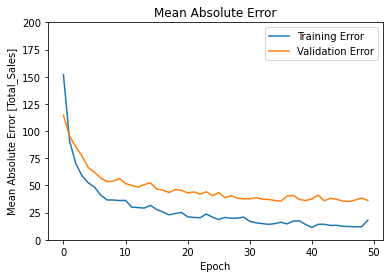

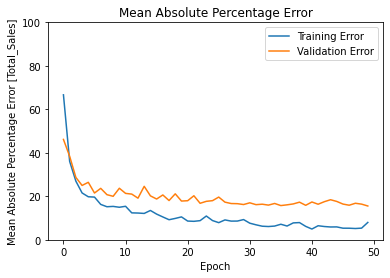

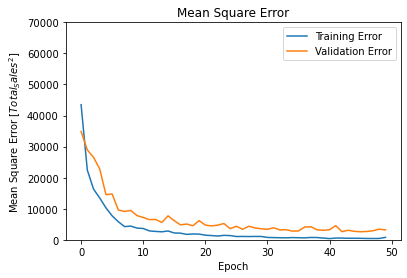

In [60]:
# Plotting KPI metrics
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error [Total_Sales]')
    plt.plot(hist['epoch'], hist['mae'],label='Training Error')
    plt.plot(hist['epoch'], hist['val_mae'],label='Validation Error')
    plt.legend()
    plt.title('Mean Absolute Error')
    plt.ylim([0,200])
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Percentage Error [Total_Sales]')
    plt.plot(hist['epoch'], hist['mape'],label='Training Error')
    plt.plot(hist['epoch'], hist['val_mape'],label='Validation Error')
    plt.legend()
    plt.title('Mean Absolute Percentage Error')
    plt.ylim([0,100])
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$Total_Sales^2$]')
    plt.plot(hist['epoch'], hist['mse'],label='Training Error')
    plt.plot(hist['epoch'], hist['val_mse'],label='Validation Error')
    plt.legend()
    plt.title('Mean Square Error')
    plt.ylim([0,70000])
    

    
plot_history(history)

**The plots shows absolute error increasing for validation error. This is an example of overfitting.**

In [61]:
# Calculating Metrics
loss, mae, mape, mse = hypermodel.evaluate(norm_test, testlabel, verbose=0)

print('Testing Set Mean Absolute Error: {:5.2f} Total_Sales'.format(mae))
print('Testing Set Mean Absolute Percentage Error: {:5.2f} Total_Sales'.format(mape))
print('Testing Set Mean Squared Error: {:5.2f} Total_Sales'.format(mse))

Testing Set Mean Absolute Error: 32.32 Total_Sales
Testing Set Mean Absolute Percentage Error: 14.98 Total_Sales
Testing Set Mean Squared Error: 2486.18 Total_Sales


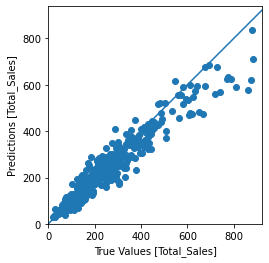

In [62]:
predictions = hypermodel.predict(norm_test).flatten()

plt.scatter(testlabel,predictions)
plt.xlabel('True Values [Total_Sales]')
plt.ylabel('Predictions [Total_Sales]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([0,5000], [0,5000])

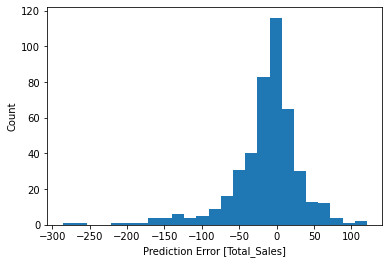

In [63]:
#Histogram of errors
error = predictions - testlabel
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Total_Sales]')
_ = plt.ylabel('Count')

In [64]:
hypermodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               26624     
_________________________________________________________________
dense_1 (Dense)              (None, 416)               213408    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                26688     
_________________________________________________________________
dense_3 (Dense)              (None, 224)               14560     
_________________________________________________________________
dense_4 (Dense)              (None, 160)               36000     
_________________________________________________________________
dense_5 (Dense)              (None, 384)               61824     
_________________________________________________________________
dense_6 (Dense)              (None, 288)               1

In [65]:
# Reindexing for plot
predictions1 = pd.Series(predictions)

testlabel1 = testlabel
testlabel1.index = predictions1.index

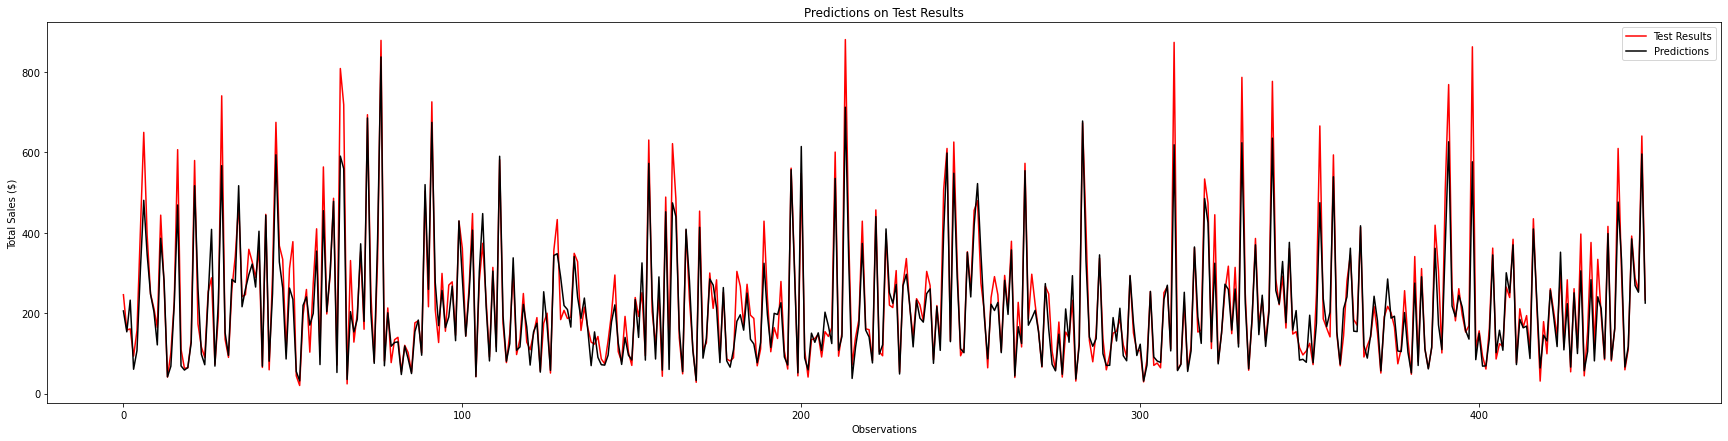

In [66]:
#Plotting predictions
x = list(range(0,450))
plt.figure(figsize=(30,7))
plt.plot(x, testlabel1, 'r', label='Test Results')
plt.plot(x, predictions1, '-k', label='Predictions')
plt.xlabel('Observations')
plt.ylabel('Total Sales ($)')
plt.title('Predictions on Test Results')
plt.legend()
plt.savefig('1B_toyotaSP500_Graph.pdf')
plt.show()